In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
seed = 161
# random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
env = gym.make('CartPole-v0')
# env = env.unwrapped
env.seed(seed);

In [4]:
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
def discretize(c_pos_val, c_vel_val, p_ang_val, p_vel_val, c_pos_s, c_vel_s, p_ang_s, p_vel_s):
    c_pos_indx = np.where(c_pos_s >= c_pos_val)[0][0].astype(int)
    c_vel_indx = np.where(c_vel_s >= c_vel_val)[0][0].astype(int)
    p_ang_indx = np.where(p_ang_s >= p_ang_val)[0][0].astype(int)
    p_vel_indx = np.where(p_vel_s >= p_vel_val)[0][0].astype(int)
    return [c_pos_indx, c_vel_indx, p_ang_indx, p_vel_indx]

In [6]:
QUANTIZATION_LEVEL = 40

In [7]:
Q_TABLE = np.zeros((QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL, 
                    N_ACTIONS))

In [8]:
# S_FILENAME = 'cartpole_limited'
# M_FILENAME = S_FILENAME+'_Q_TABLE_'+str(QUANTIZATION_LEVEL)+'.npy'
# Q_TABLE = np.load(M_FILENAME)

In [9]:
c_pos_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
c_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
p_ang_s = np.linspace(-1, 1, QUANTIZATION_LEVEL)
p_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)

In [10]:
LR = 1e-1
GAMMA = 0.9
NO_OF_EPISODES = 50000
EPSILON = 0.9

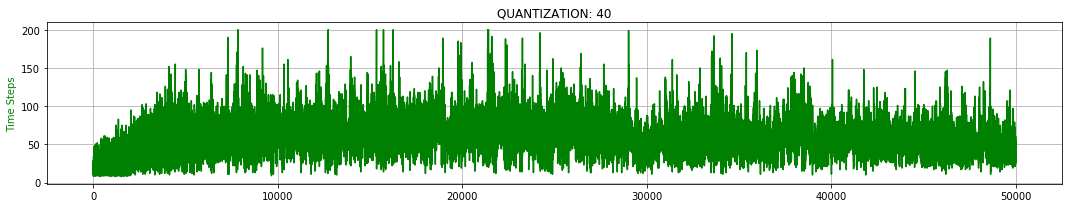

In [11]:
#TRAINING
time_rec = []
for i_episode in range(NO_OF_EPISODES):
    time_steps = 0
    s = env.reset()
    while True:
#         env.render()
        [c_pos_state, 
        c_vel_state, 
        p_ang_state, 
        p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                 c_pos_s, 
                                 c_vel_s, 
                                 p_ang_s, 
                                 p_vel_s)
        
        time_steps += 1
        if np.random.uniform() > EPSILON:   # greedy
            a = np.random.randint(0, N_ACTIONS)
        else:
            a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

         # take action
        s_, r, done, info = env.step(a)
        
        #discretize next_state
        [next_c_pos_state, 
        next_c_vel_state, 
        next_p_ang_state, 
        next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                      c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)
        
        # learn
        this_state = tuple([c_pos_state, 
                      c_vel_state, 
                      p_ang_state, 
                      p_vel_state])
        
        next_state = tuple([ next_c_pos_state, 
                       next_c_vel_state, 
                       next_p_ang_state, 
                       next_p_vel_state])
        
        Q_TABLE[this_state][a] = Q_TABLE[this_state][a] + LR * (r + GAMMA * Q_TABLE[next_state].max() - 
                                                                 Q_TABLE[this_state][a])
        if done:
            time_rec = np.append(time_rec, time_steps)
            break
        s = s_
env.close()

fig = plt.figure(figsize = (15,3))

ax2 = fig.add_subplot(1, 1, 1)
data = time_rec
ax2.set_title("QUANTIZATION: "+str(QUANTIZATION_LEVEL))
ax2.plot(data, color = 'g')
# ax2.plot(np.ones_like(data)*200, 'g--')

ax2.set_ylabel('Time Steps',color = 'g')
# ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()

In [12]:
NO_OF_EPISODES = 1000

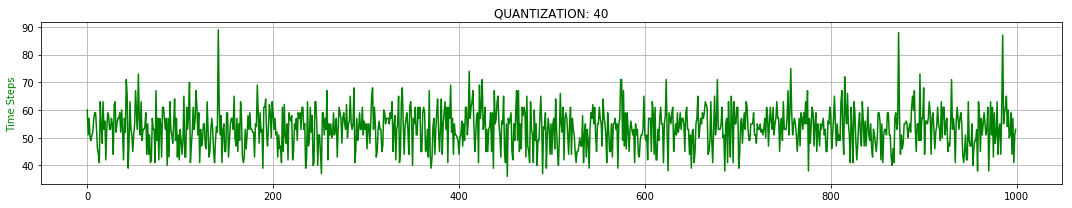

In [13]:
#TESTING
time_rec = []
# S_FILENAME = 'cartpole_limited'
# M_FILENAME = S_FILENAME +'_Q_TABLE_'+str(QUANTIZATION_LEVEL)+'.npy'
# Q_TABLE = np.load(M_FILENAME)


for i_episode in range(NO_OF_EPISODES):

    time_steps = 0
    s = env.reset()
    while True:
#         env.render()

        [c_pos_state, 
        c_vel_state, 
        p_ang_state, 
        p_vel_state] = discretize(s[0],    s[1],    s[2],    s[3],
                                 c_pos_s, c_vel_s, p_ang_s, p_vel_s)

        time_steps += 1
        a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

        # take action
        s_, r, done, info = env.step(a)
        
        

        if done:
            time_rec = np.append(time_rec, time_steps)

            break
        s = s_
env.close()
fig = plt.figure(figsize = (15,3))

ax2 = fig.add_subplot(1, 1, 1)
data = time_rec
ax2.set_title("QUANTIZATION: "+str(QUANTIZATION_LEVEL))
ax2.plot(data, color = 'g')
# ax2.plot(np.ones_like(data)*200, 'g--')

ax2.set_ylabel('Time Steps',color = 'g')
# ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()